In [17]:
import glob
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

In [18]:
# --- 1. CONFIGURATION ---
SOURCE_DIR = "./raw_data/4_evening"
VIDEO_PATH = SOURCE_DIR + "/output.mp4"
TEMPLATE_PATH = SOURCE_DIR + "/vessel_template.png"
CHECKPOINT = "./sam2.1_hiera_large.pt" 
CONFIG = "configs/sam2.1/sam2.1_hiera_l.yaml"

# --- 2. LOAD MODEL ---
# Select device (GPU if available for speed, else CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

sam2_model = build_sam2(CONFIG, CHECKPOINT, device=device)
predictor = SAM2ImagePredictor(sam2_model)

Using device: cpu


In [19]:
# Multi-scale template matching (from paste_morse_flash.ipynb)
def multiscale_match(frame, template, scales=np.linspace(0.8, 1.2, 15)):
    th, tw = template.shape[:2]
    best = {'val': -1, 'loc': None, 'scale': None, 'w': None, 'h': None}
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    tpl_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY) if len(template.shape) == 3 else template

    for s in scales:
        nw, nh = int(tw * s), int(th * s)
        if nw < 8 or nh < 8 or nw > frame.shape[1] or nh > frame.shape[0]:
            continue
        tpl_resized = cv2.resize(tpl_gray, (nw, nh), interpolation=cv2.INTER_AREA)
        res = cv2.matchTemplate(gray, tpl_resized, cv2.TM_CCOEFF_NORMED)
        _, maxVal, _, maxLoc = cv2.minMaxLoc(res)
        if maxVal > best['val']:
            best.update({'val': maxVal, 'loc': maxLoc, 'scale': s, 'w': nw, 'h': nh})

    if best['loc'] is None:
        return None
    x, y = best['loc']
    return (x, y, best['w'], best['h'], best['val'])

In [20]:
sam2_model = build_sam2(CONFIG, CHECKPOINT, device=device)
predictor = SAM2ImagePredictor(sam2_model)

In [21]:
# --- 3. LOAD IMAGE ---
image = cv2.imread(TEMPLATE_PATH)

if image is None:
    raise ValueError("Image not found. Check the path.")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # SAM2 expects RGB

predictor.set_image(image_rgb)

Using Image-sized Box: [[   0    0 1021  310]]
Mask is inverted (Sky detected). Flipping mask...
Selected mask index 2 with score 0.96


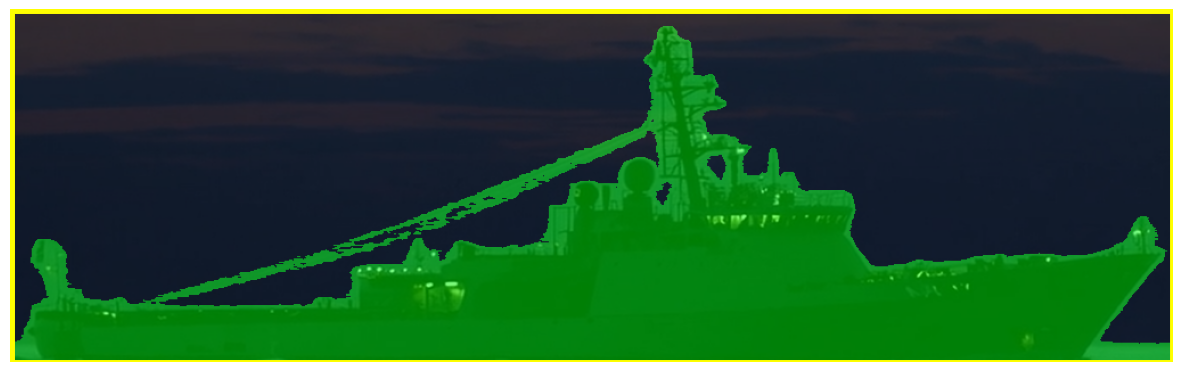

In [22]:
# --- 1. DEFINE BOX (Whole Image) ---
# Get exact image dimensions
height, width = image_rgb.shape[:2]

# Format: [x_min, y_min, x_max, y_max]
# We use a 1-pixel margin (1 to width-1) to avoid edge confusion
box_prompt = np.array([[0, 0, width, height]])

print(f"Using Image-sized Box: {box_prompt}")

# --- 2. PREDICT WITH BOX ---
masks, scores, _ = predictor.predict(
    point_coords=None,      # No points needed
    point_labels=None,
    box=box_prompt,         # The 'Whole Image' prompt
    multimask_output=True   # Ask for multiple options just in case
)

# --- 3. SELECT THE BEST MASK ---
# SAM returns 3 masks. Since we used a huge box, 
# we usually want the one that is LARGE but not the entire square.
# We pick the mask with the highest confidence score.
best_idx = np.argmax(scores)
ship_mask = masks[best_idx]

# Ensure it is Boolean (True/False) for visualization
ship_mask_bool = ship_mask > 0.0

if ship_mask_bool[0, 0] == True:  # Check if top-left pixel is Green
    print("Mask is inverted (Sky detected). Flipping mask...")
    ship_mask_bool = ~ship_mask_bool

print(f"Selected mask index {best_idx} with score {scores[best_idx]:.2f}")

# --- 4. VISUALIZATION ---
plt.figure(figsize=(15, 10))
plt.imshow(image_rgb)

# Green overlay
overlay = np.zeros_like(image_rgb)
overlay[ship_mask_bool] = [0, 255, 0] 
plt.imshow(overlay, alpha=0.5)

# Draw the box for confirmation (Yellow border)
x0, y0, x1, y1 = box_prompt[0]
plt.gca().add_patch(plt.Rectangle((x0, y0), x1-x0, y1-y0, 
                                  edgecolor='yellow', facecolor='none', lw=5))

plt.axis('off')
plt.show()

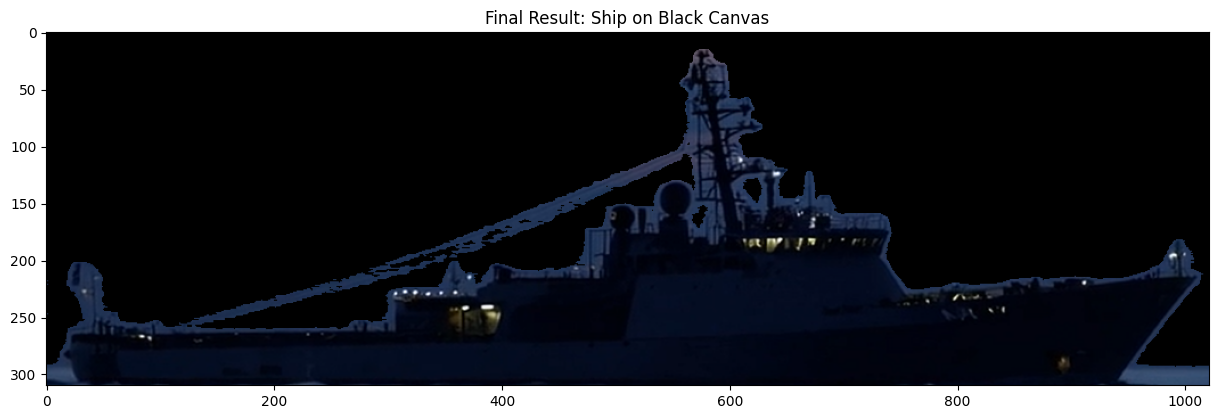

In [26]:
# --- 1. PREPARE THE CANVAS ---
# Create a black image with the same dimensions (Height, Width, 3 Channels)
template = np.zeros_like(image_rgb)

# --- 2. APPLY THE MASK ---
# Copy pixels from the original image ONLY where the mask is True
# This effectively "cuts" the ship out and "pastes" it onto the black canvas
template[ship_mask_bool] = image_rgb[ship_mask_bool]

# --- 3. VISUALIZE ---
plt.figure(figsize=(15, 10))

# Show the result
plt.imshow(template)
plt.title("Final Result: Ship on Black Canvas")
# plt.axis('off')
plt.show()

In [57]:
def multiscale_match(frame, template, scales=np.linspace(0.8,1.2,15)):
    th, tw = template.shape[:2]
    best = {'val': -1, 'loc': None, 'scale': None, 'w':None, 'h':None}
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    tpl_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    _, template_mask = cv2.threshold(tpl_gray, 1, 255, cv2.THRESH_BINARY)

    for s in scales:
        nw, nh = int(tw * s), int(th * s)
        if nw < 8 or nh < 8 or nw > frame.shape[1] or nh > frame.shape[0]:
            continue
        tpl_resized = cv2.resize(tpl_gray, (nw, nh), interpolation=cv2.INTER_AREA)
        tpl_resized_mask = cv2.resize(template_mask, (nw, nh), interpolation=cv2.INTER_AREA)
        res = cv2.matchTemplate(
            gray, 
            tpl_resized, 
            cv2.TM_CCORR_NORMED,
            mask=tpl_resized_mask
            )
        _, maxVal, _, maxLoc = cv2.minMaxLoc(res)
        if maxVal > best['val']:
            best.update({'val': maxVal, 'loc': maxLoc, 'scale': s, 'w': nw, 'h': nh})

    if best['loc'] is None:
        return None
    x, y = best['loc']
    return (x, y, best['w'], best['h'], best['val'])

In [58]:
# --- Run cv2 on output.mp4: multi-scale template matching + bounding box ---
# Uses same method as paste_morse_flash.ipynb (multiscale_match)

template_img = cv2.imread(TEMPLATE_PATH)
if template_img is None:
    raise FileNotFoundError(f"Template not found: {TEMPLATE_PATH}")

template_img = cv2.cvtColor(template, cv2.COLOR_RGB2BGR)

cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise FileNotFoundError(f"Video not found: {VIDEO_PATH}")

fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
delay = max(1, int(1000 / fps))

# Output video with bounding boxes drawn
out_path = SOURCE_DIR + "/output_tracked.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(out_path, fourcc, fps, (width, height))

# Multi-scale range like paste_morse_flash (0.7–1.3, 12 steps)
scales = np.linspace(0.5, 0.8, 10)

frame_idx = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    match = multiscale_match(frame, template_img, scales=scales)

    if match is not None:
        x, y, w, h, val = match
        # Bounding box (green)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # Match score label
        cv2.putText(
            frame, f"Match: {val:.2f}", (x, y - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2
        )

    out.write(frame)
    frame_idx += 1
    cv2.imshow('Frame', frame)
    if cv2.waitKey(delay) & 0xFF == ord('q'):
        break

cap.release()
out.release()
cv2.destroyAllWindows()
print(f"Done. Wrote {frame_idx} frames to {out_path}")

Done. Wrote 599 frames to ./raw_data/4_evening/output_tracked.mp4
